In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.optimize import curve_fit
from scipy.stats import chi2

from pathlib import Path
import os

In [25]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
rc('font', **font)

In [26]:
root = Path(os.getcwd())
dp = root / "Data"
from utils import plotpath

In [1]:
def plot_residuals(x, y, y_fit, y_unc, xlabel="", ylabel="Residuals", save_as=""):
    residuals = y - y_fit
    plt.errorbar(x, residuals, yerr=y_unc, fmt='o', ecolor='lightgray', elinewidth=2, capsize=1)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_as:
        plt.savefig(plotpath / save_as, bbox_inches="tight")
    plt.show()

def calculate_chi2(y, y_fit, y_unc, k):
    """
    Calculate the chi-squared statistic, reduced chi-squared, and chi-squared probability.
    Parameters:
    y (array-like): Observed data points.
    y_fit (array-like): Fitted data points.
    y_unc (array-like): Uncertainties in the observed data points.
    k (int): Number of fitted parameters.
    Returns:
    tuple: A tuple containing:
        - chi (float): The chi-squared statistic.
        - reduced_chi2 (float): The reduced chi-squared statistic.
        - chi2_prob (float): The probability of obtaining a chi-squared value at least as extreme as the one computed, given the degrees of freedom.
    """

    chi = np.sum(((y - y_fit) / y_unc) ** 2)
    dof = len(y) - k
    reduced_chi2 = chi / dof
    chi2_prob = 1 - chi2.cdf(chi, dof)
    return chi, reduced_chi2, chi2_prob

In [28]:
def format_parameters_with_errors(parameters, errors):
    def round_to_significant_figures(x, sig_figs=1):
        if x == 0:
            return 0
        else:
            return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)

    formatted_values = []
    for param, err in zip(parameters, errors):
        # Round error to one significant figure
        rounded_err = round_to_significant_figures(err, sig_figs=1)
        # Adjust parameter value to match error precision
        param_precision = int(np.floor(np.log10(rounded_err)))
        rounded_param = round(param, -param_precision)
        
        formatted_values.append(f"{rounded_param} ± {rounded_err}")

    return formatted_values

In [29]:
from utils import datapath, plotpath 
dp = datapath 

[[-2.5000e+01 -2.4975e+01 -2.4950e+01 ...  2.4925e+01  2.4950e+01
   2.4975e+01]
 [-2.0100e-02 -1.0050e-02  1.0050e-02 ... -2.5130e-02  0.0000e+00
   1.0050e-02]
 [ 2.0100e-02 -2.5130e-02 -2.0100e-02 ... -2.0100e-02 -2.0100e-02
  -2.0100e-02]]
[-25.    -24.975 -24.95  ...  24.925  24.95   24.975]
-25.0
[0.0000e+00 2.5000e-02 5.0000e-02 ... 4.9925e+01 4.9950e+01 4.9975e+01]


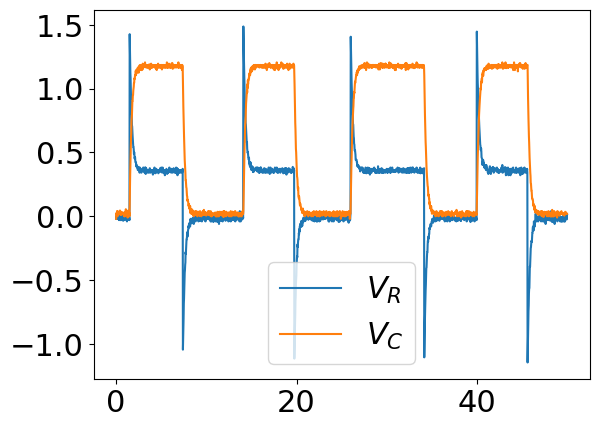

In [30]:
fp = dp/"e1_ch1_no_shift.csv"

ds = np.genfromtxt(fp, delimiter=",", skip_header=2)

d = np.where(ds == np.nan, 0, ds)
d = np.transpose(d)

print(d)
print(d[0])
print(d[0][0])

t = d[0] - d[0][0]  # time (s)
Vr = d[1]           # voltage across resistor (V)
Vc = -d[2]          # voltage acrross capacitor (V)

print(t)

plt.plot(t, Vr, label=r"$V_R$")
plt.plot(t, Vc, label=r"$V_C$")
plt.legend()


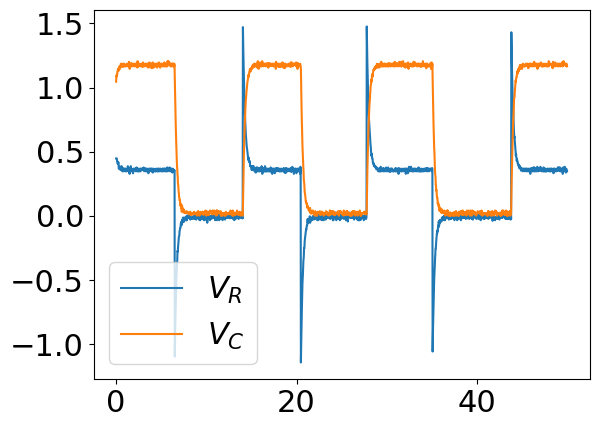

In [31]:
fp = dp / "e1.csv"

ds2 = np.genfromtxt(fp, delimiter=",", skip_header=2)

d2 = np.where(ds2 == np.nan, 0, ds2)
d2 = np.transpose(d2)



t2 = d2[0] - d2[0][0]  # time (s)
Vr2 = d2[1]           # voltage across resistor (V)
Vc2 = -d2[2]          # voltage acrross capacitor (V)

plt.plot(t2, Vr2, label=r"$V_R$")
plt.plot(t2, Vc2, label=r"$V_C$")
plt.legend()

## Uncertainties 
Reference: [Keysight FAQs for Uncertainty](https://docs.keysight.com/kkbopen/understanding-voltage-measurement-accuracy-for-infiniivision-oscilloscopes-584425356.html#:~:text=and%20Infiniium%20oscilloscopes.-,DC%20vertical%20offset%20accuracy,up%20and%20down%20the%20screen.)
- Vertical scale was 500mV/div (? not fully sure but makes sense) with 8 divisions (ranged from -2V to 2V) 
- No vertical offset
Uncertainty in voltage readings given by single-cursor accuracy
- Different than RSS (Root Mean Square), we sum errors from sources linearly instead of in quadrature 

In [32]:
from utils import keysight_unc

v_div = 0.5 # 500mV/div 
vu = keysight_unc(0.5) * np.ones(t.shape)
vu[0]

0.187625

In [ ]:
indices = np.where((Vr > 1.4) | (Vr < -1.04))[0]
indices = np.append(indices, len(Vr) - 1)
t[indices]

vrch = np.mean(Vr[(indices[1] - 21):(indices[1] - 1)])
vcch = np.mean(Vc[(indices[1] - 21):(indices[1] - 1)])

vch = np.mean(Vr[indices[0]:indices[1]] + Vc[indices[0]:indices[1]])
vch, vrch, vcch


print(vu)

[0.187625 0.187625 0.187625 ... 0.187625 0.187625 0.187625]


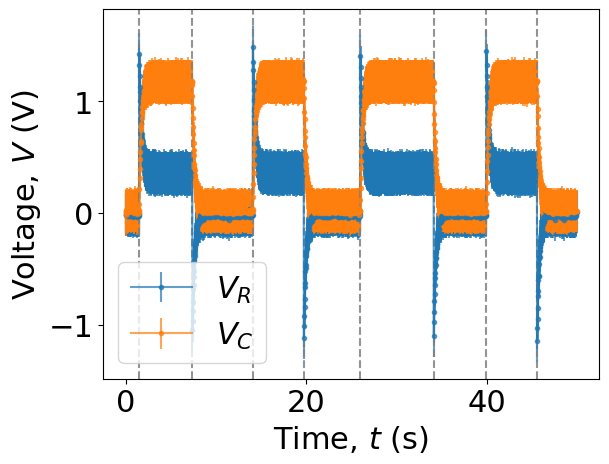

In [34]:
plt.errorbar(t, Vr, label=r"$V_R$", yerr=vu, marker='.', alpha=0.7)
plt.errorbar(t, Vc, label=r"$V_C$", yerr=vu, marker='.', alpha=0.7)

for idx in indices[:-1]:
    plt.axvline(x=t[idx], color='gray', linestyle='--', alpha=0.85)

plt.legend()
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Voltage, $V$ (V)")
plt.savefig(plotpath / "e1_data1", bbox_inches="tight")

In [35]:
indices2 = np.where((Vr2 > 1.4) | (Vr2 < -1.05))[0]
indices2 = np.append(indices2, len(Vr2) - 1)
t2[indices2]

array([ 6.5  , 14.05 , 20.475, 27.775, 35.075, 43.8  , 49.975])

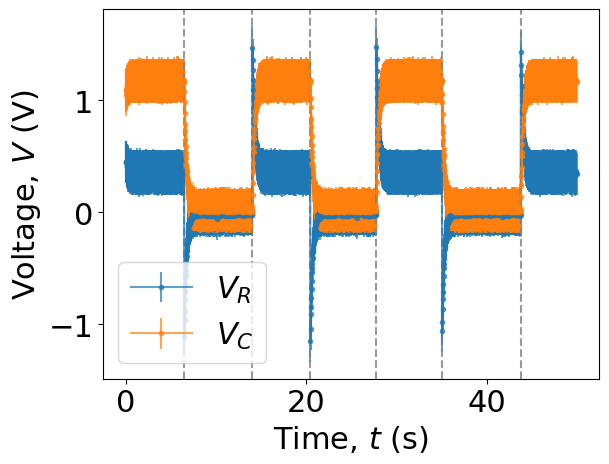

In [36]:
plt.errorbar(t2, Vr2, label=r"$V_R$", yerr=vu, marker='.', alpha=0.7)
plt.errorbar(t2, Vc2, label=r"$V_C$", yerr=vu, marker='.', alpha=0.7)

for idx in indices2[:-1]:
    plt.axvline(x=t2[idx], color='gray', linestyle='--', alpha=0.8)

plt.legend()
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Voltage, $V$ (V)")
plt.savefig(plotpath / "e1_data2", bbox_inches="tight")

# Theory
Have $C = Q/V_c \implies I(t) = CV_c'(t)$
For RC circuit, 
$$
\begin{align*}
V &= V_c(t) + V_r(t) \\ 
&= V_c(t) + RCV_c'(t) 
\end{align*}
$$
Transient solution, $V_c(t) = Ae^{-t/(RC)}$. Steady-State, particular $V_c(t) = V$ works. So 
$V_c(t) = Ae^{-t/RC} + V$
where $A = V_c(0) - V$. Then $V_r(t) = V - V_c(t) = Ae^{-t/RC}$

In [37]:
V0 = 1.5 
R = 477e3 
C = 1e-6

tau_t = R*C

tts = np.linspace(0, 6, 1000)
tts1, _ = np.array_split(tts, 2)

vcs1 = V0 * (1 - np.exp(-tts1/tau_t))
vcs2 = V0 * np.exp(-tts1/tau_t)

vrs1 = V0 * np.exp(-tts1/tau_t)
vrs2 = -V0 * np.exp(-tts1/tau_t)

vcs = np.concat((vcs1, [np.nan], vcs2))
vrs =  np.concat((vrs1, [np.nan], vrs2))

V0s = np.concatenate((V0 * np.ones(tts1.shape), [np.nan], np.zeros(_.shape)))

tts = np.concatenate((tts1, [np.nan], tts1 + tts1[-1]))

plt.plot(tts, vrs, label=r"$V_r$")
plt.plot(tts, vcs, label=r"$V_c$")

plt.plot(tts, V0s, label=r"$V_0$", color='gray', linestyle='--')
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Voltage, $V$ (V)")
plt.legend()

plt.savefig(plotpath / "e1_rc_theory", bbox_inches="tight")

AttributeError: module 'numpy' has no attribute 'concat'

In [ ]:
from utils import meterman37xr_unc

batteryV = "1.54"
meterman37xr_unc(batteryV)

0.05154

In [ ]:
# Exponential fitting function 
def expfit(x, A, tau, V):
    return A * np.exp(-x/tau) + V

In [ ]:
def fitseg(i, p=True, dataset=0, save=False):
    if dataset == 0:
        idxs = indices 
        times = t 
        vrs = Vr 
        vcs = Vc 
    else: 
        idxs = indices2 
        times = t2 
        vrs = Vr2 
        vcs = Vc2 

    i1 = idxs[i] 
    i2 = idxs[i + 1]

    start = times[i1]
    tp = times[i1:i2] - start
    vrp = vrs[i1:i2]
    vcp = vcs[i1:i2]
    vup = vu[i1:i2]

    poptr, pcovr = curve_fit(expfit, tp, vrp, sigma = vu[i1:i2], p0=(vrp[0], 0.23, vrp[-1]), absolute_sigma=True)
    poptc, pcovc =  curve_fit(expfit, tp, vcp, sigma = vu[i1:i2], p0=(vcp[0], 0.23, vcp[-1]), absolute_sigma=True)

    perrr = np.sqrt(np.diag(pcovr))
    perrc = np.sqrt(np.diag(pcovc))

    if p:
        ts = np.linspace(tp[0], tp[-1], 100)
        plt.errorbar(tp + start, vrp, marker=".",yerr=vup, alpha=0.3, label=r"$V_r$ Data")
        plt.errorbar(tp + start, vcp, marker=".",yerr=vup, alpha=0.3, label=r"$V_c$ Data")

        plt.plot(ts + start, expfit(ts, *poptr), label=r"$V_r$ Fit")
        plt.plot(ts + start, expfit(ts, *poptc), label=r"$V_c$ Fit")
        plt.legend() 

        plt.xlabel(r"Time, $t$ (s)")
        plt.ylabel(r"Voltage, $V$ (V)")

    if save:
        plt.savefig(plotpath / f"e1_expfit_{i}_{dataset}", bbox_inches="tight")
    return poptr, perrr, poptc, perrc

(array([1.07522525, 0.23670552, 0.35708651]), array([0.1101655 , 0.03780326, 0.01333083]), array([-1.07944166,  0.23013   ,  1.17542562]), array([0.1114163 , 0.03702562, 0.01329561]))
['1.1 ± 0.1', '0.24 ± 0.04', '0.36 ± 0.01']
['-1.1 ± 0.1', '0.23 ± 0.04', '1.18 ± 0.01']


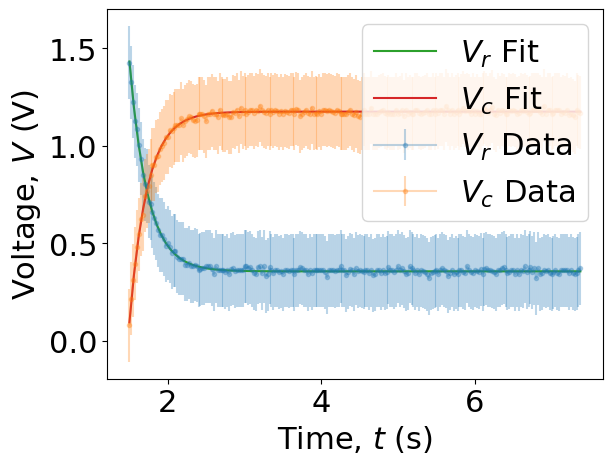

In [ ]:
ps00 = fitseg(0, dataset=0, save=True)
print(ps00)
print(format_parameters_with_errors(ps00[0], ps00[1]))
print(format_parameters_with_errors(ps00[2], ps00[3]))

(array([-1.06060202,  0.23236841, -0.01137876]), array([0.11097501, 0.0373098 , 0.01062583]), array([1.05912107, 0.23398917, 0.01848693]), array([0.11066651, 0.0375127 , 0.01063025]))
['-1.1 ± 0.1', '0.23 ± 0.04', '-0.01 ± 0.01']
['1.1 ± 0.1', '0.23 ± 0.04', '0.02 ± 0.01']


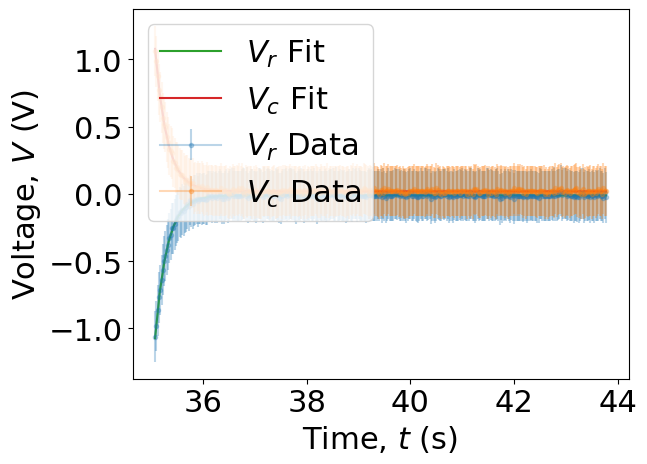

In [ ]:
ps41 = fitseg(4, dataset=1, save=True)
print(ps41)
print(format_parameters_with_errors(ps41[0], ps41[1]))
print(format_parameters_with_errors(ps41[2], ps41[3]))

In [ ]:
taus = []
tau_es = []
for i in range(len(indices) - 1):
    pr, per, pc, pec = fitseg(i, False)

    taus.extend([pr[1], pc[1]])
    tau_es.extend([per[1], pec[1]])

for i in range(len(indices2) - 1):
    pr, per, pc, pec = fitseg(i, False, dataset=1)

    taus.extend([pr[1], pc[1]])
    tau_es.extend([per[1], pec[1]])

In [ ]:
tau_mean = np.mean(taus)
tau_unc = np.std(taus)/np.sqrt(len(taus))

print(f"tau = {tau_mean} +/- {tau_unc}")

tau = 0.23498454492232004 +/- 0.00047142464803390607


In [ ]:
# Exponential fitting function 
def expfit2(x, A, tau):
    return A * np.exp(-x/tau)

In [ ]:
def fitseg2(i, p=True, dataset=0, save=False, res=False):
    if dataset == 0:
        idxs = indices 
        times = t 
        vrs = Vr 
        vcs = Vc 
    else: 
        idxs = indices2 
        times = t2 
        vrs = Vr2 
        vcs = Vc2 

    i1 = idxs[i] 
    i2 = idxs[i + 1]

    start = times[i1]
    tp = times[i1:i2] - start
    vrp = vrs[i1:i2]
    vcp = vcs[i1:i2]
    vup = vu[i1:i2]

    # poptr, pcovr = curve_fit(expfit, tp, vrp, sigma = vu[i1:i2], p0=(vrp[0], 0.23, vrp[-1]), absolute_sigma=True)
    poptc, pcovc =  curve_fit(expfit, tp, vcp, sigma = vu[i1:i2], p0=(vcp[0], 0.23, vcp[-1]), absolute_sigma=True)

    # perrr = np.sqrt(np.diag(pcovr))
    perrc = np.sqrt(np.diag(pcovc))

    if p:
        ts = np.linspace(tp[0], tp[-1], 100)
        # plt.errorbar(tp + start, vrp, marker=".",yerr=vup, alpha=0.3, label=r"$V_r$ Data")
        plt.errorbar(tp + start, vcp, marker=".",yerr=vup, alpha=0.3, label=r"$V_c$ Data")

        # plt.plot(ts + start, expfit(ts, *poptr), label=r"$V_r$ Fit")
        plt.plot(ts + start, expfit(ts, *poptc), label=r"$V_c$ Fit")
        plt.legend() 

        plt.xlabel(r"Time, $t$ (s)")
        plt.ylabel(r"Voltage, $V$ (V)")

    if save:
        plt.savefig(plotpath / f"e1_expfit_{i}_{dataset}", bbox_inches="tight")
        
    plt.show()
    if res:
        vcpfit = expfit(tp, *poptc)
        plot_residuals(tp + start, vcp, vcpfit, vup, xlabel=r"Time, $t$ (s)", ylabel="Residuals (V)", save_as="e1_rc_resfit")

        print(calculate_chi2(vcp, vcpfit, vup, len(poptc)))

    return poptc, perrc

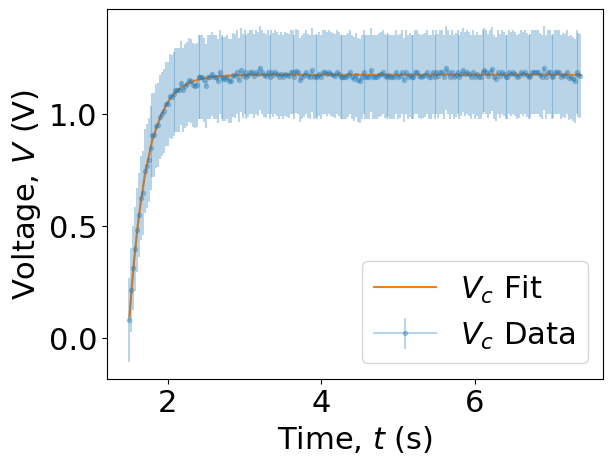

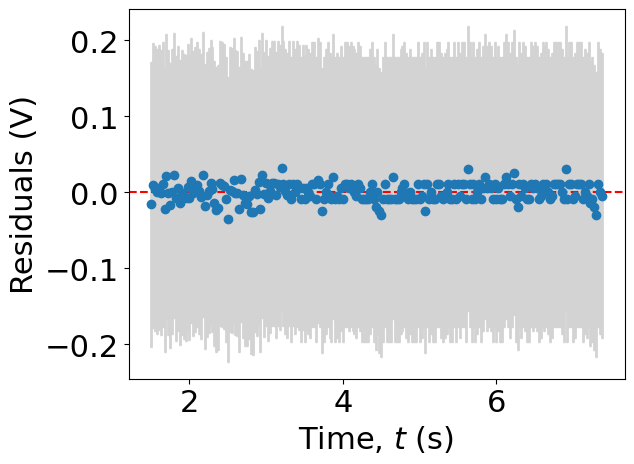

(np.float64(0.9426728917154431), np.float64(0.004045806402212202), np.float64(1.0))
[-1.07944166  0.23013     1.17542562] [0.1114163  0.03702562 0.01329561]


In [ ]:
pop, perr = fitseg2(0, True, 0, True, True)
print(pop, perr)

In [ ]:
from utils import plot_residuals

def gaussfit(x, A, mean, width):
    return A*np.exp(-(x-mean)**2/(2*width**2)) / (width*np.sqrt(2*np.pi))


def gaussian_histogram(data, num_bins, bin_range=(), fit = False, res = False, save=False):
    if bin_range == ():
        bin_range = (np.min(data), np.max(data))
        
    n, bin_edges, _ = plt.hist(data, bins=num_bins, range=bin_range, color='k', histtype='step', label='Data')
    # This plots the histogram AND saves the counts and bin_edges for later use

    xlabel = 'Time Constant' 
    axes = plt.gca()
    plt.xlabel(rf"{xlabel}, $\tau$ (s)")
    plt.ylabel('Counts')
    plt.xlim(bin_range)  
    
    # If the legend covers some data, increase the plt.xlim value, maybe (0,0.5)
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    """
    This gives us the x-data which are the centres of each bin.
    This is visually better for plotting errorbars.
    More important, it's the correct thing to do for fitting the
    Gaussian to our histogram.
    It also fixes the shape -- len(n) < len(bin_edges) so we
    cannot use 
    plt.plot(n, bin_edges)
    as it will give us a shape error.
    """
    
    sig = np.sqrt(n)
    sig=np.where(sig==0, 1, sig) 
    # The uncertainty on 0 count is 1, not 0. Replace all 0s with 1s.
    
    plt.errorbar(bin_centers, n, yerr=sig, fmt='none', c='k')
    # This adds errorbars to the histograms, where each uncertainty is sqrt(y)

    chi_prob = 0
    if fit:
        A0 = np.max(n)
        mu0 = np.average(bin_centers, weights=n)
        sigma0 = np.sqrt(np.average((bin_centers - mu0)**2, weights=n))
        p0_guess = (A0, mu0, sigma0)
        
        popt, pcov = curve_fit(gaussfit, bin_centers, n, 
                     sigma = sig, p0=p0_guess, absolute_sigma=True)
        perr = np.diag(pcov) # uncertainty in optimal params is root of diagonal of covariance matrix
        n_fit = gaussfit(bin_centers, *popt)
        """
        n_fit is our best fit line using our data points.
        Note that if you have few enough bins, this best fit
        line will have visible bends which look bad, so you
        should not plot n_fit directly. See below.
        """
        
        chisquared = np.sum( ((n - n_fit)/sig )**2)
        dof = num_bins - len(popt)
        # Number of degrees of freedom is the number of data points less the number of fitted parameters
        
        x_bestfit = np.linspace(bin_edges[0], bin_edges[-1], 100)
        y_bestfit = gaussfit(x_bestfit, *popt) 

        # Best fit line smoothed with 1000 datapoints. Don't use best fit lines with 5 or 10 data points!
        plt.plot(x_bestfit, y_bestfit, label='Fit')

        chi2_prob = 1-chi2.cdf(chisquared,dof)

        
    plt.legend(loc=1)
    plt.show()
    
    res_name = ""
    if save: 
        plt.savefig(plotpath / "e1_tau_hist", bbox_inches="tight")
        res_name = "e1_tau_hist_res"
    if res: 
        plot_residuals(bin_centers, n, n_fit, sig,rf"{xlabel}, $\tau$ (s)", res_name)

    if fit: 
        return (popt, perr, (chisquared, dof, chi2_prob))


In [ ]:
bin_range = np.max(taus) - np.min(taus)
num_bins = 20 

bin_width = bin_range/num_bins 
bin_width, tau_unc

np.sqrt(10)/10

np.float64(0.31622776601683794)

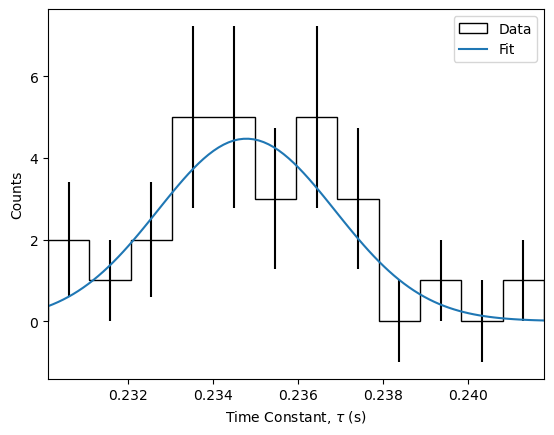

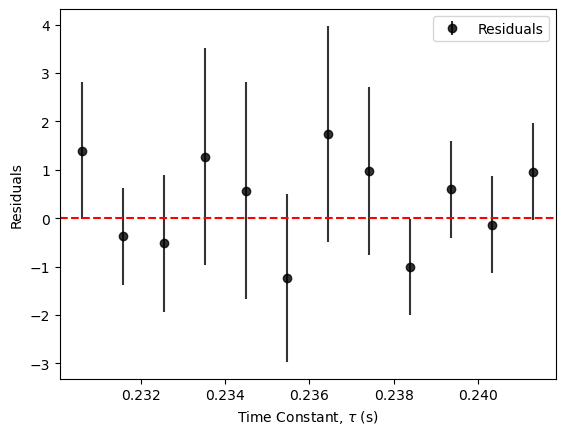

<Figure size 640x480 with 0 Axes>

In [ ]:
tau_fit = gaussian_histogram(taus, 12, fit=True, res=True, save=True)

In [ ]:
print(tau_fit)
print(format_parameters_with_errors(tau_fit[0], tau_fit[1]))

(array([0.02336981, 0.234793  , 0.00208494]), array([2.53370062e-05, 2.42919883e-07, 2.00105888e-07]), (np.float64(5.397095563596964), 9, np.float64(0.7984103763869744)))
['0.02337 ± 3e-05', '0.234793 ± 2e-07', '0.0020849 ± 2e-07']


In [ ]:
tau_fit[2][0]/ tau_fit[2][1]

np.float64(0.5996772848441071)